In [1]:
import pandas as pd
import numpy as np
import src.text_analysis as ta
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
set_matplotlib_formats('svg')

In [2]:
amz_rev = pd.read_csv('output/amz.csv')

In [3]:
amz_rev.isna().any()

overall           False
verified          False
reviewerID        False
asin              False
reviewerName      False
reviewText        False
summary           False
reviewTime        False
vote              False
image             False
Multiple_r_day    False
Same_r_text       False
spam_reviewer     False
polarity          False
subjectivity      False
num_words         False
flesch_score      False
verbs_ratio       False
nouns_ratio       False
prp_ratio         False
dtype: bool

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tfidf=TfidfVectorizer(min_df=.02, max_df =0.08, tokenizer=ta.spacy_tokenizer)
tfidf_matrix=tfidf.fit_transform(amz_rev.reviewText)
terms=tfidf.get_feature_names()
tfidf_matrix.shape

(8000, 96)

In [6]:
terms[:10]

['...', '2', '3', '4', '5', '6', 'actually', 'awesome', 'battery', 'best']

In [7]:
pd.DataFrame(tfidf_matrix).head()


,0
0,"(0, 94)\t0.18654729397659953\n (0, 69)\t0.2..."
1,"(0, 27)\t1.0"
2,"(0, 54)\t0.5264578648577342\n (0, 88)\t0.44..."
3,"(0, 33)\t1.0"
4,"(0, 76)\t0.3593848102975635\n (0, 75)\t0.30..."


In [8]:
from sklearn.metrics.pairwise import cosine_similarity as cos
dist=1-cos(tfidf_matrix)
dist.shape

(8000, 8000)

In [9]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2,algorithm='arpack', n_iter=5, random_state=28)
red = svd.fit_transform(dist)

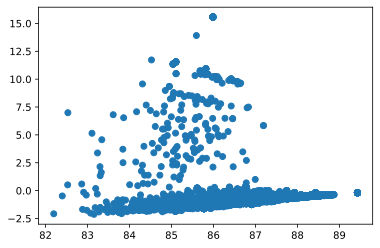

In [10]:
plt.scatter(red[:,0], red[:,1]);


In [11]:
from sklearn.cluster import KMeans

In [12]:
range_n_clusters = [2,3,4,5]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=28)
    cluster_labels=clusterer.fit_predict(red)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(red, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.860142879659566
For n_clusters = 3 The average silhouette_score is : 0.6199848811795386
For n_clusters = 4 The average silhouette_score is : 0.6332417409208483
For n_clusters = 5 The average silhouette_score is : 0.6108646575777811


In [13]:
kmeans = KMeans(n_clusters=3, random_state=28)
clusters=kmeans.fit_predict(red)
np.unique(clusters)

array([0, 1, 2], dtype=int32)

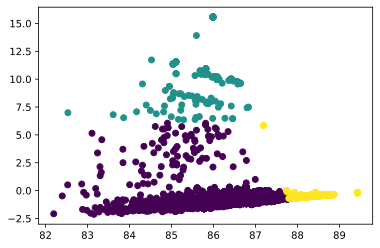

In [14]:
plt.scatter(red[:,0], red[:,1], c=clusters);


In [15]:
def get_reviewerID_from_cluster(c):
    #Associate the cluster with the reviewerID column
    return pd.Series(amz_rev['reviewerID'])[clusters==c]

def label_cluster(cluster,column):
    #Return a list with 1 if the reviewerID is in the cluster and 0 if is not. 
    reviewers_id = list(set([x for x in get_reviewerID_from_cluster(cluster)]))
    in_cluster = []
    for idx in range(len(column)):
        if column[idx] in reviewers_id:
            in_cluster.append(1)
        else:
            in_cluster.append(0)
    return in_cluster

In [16]:
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,...,2,3,4,5,6,actually,awesome,battery,best,...,thing,think,time,times,usb,use,want,way,work,worked
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.163252,0.0,0.0,0.186547,0.00000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.447452,0.0,0.0,0.000000,0.0,0.0,0.474702,0.54524
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000


In [17]:
def get_df_from_cluster(c):
    #get a poandas dataframe from the cluster
    return tfidf_df[clusters==c]

In [18]:
for x in range(0,max(np.unique(clusters)+1)):
    top_words_cluster=get_df_from_cluster(x).T.sum(axis=1).sort_values(ascending=False)
    display(top_words_cluster.head(20))

fit           238.663938
price         238.148528
perfect       226.985082
quality       225.189399
fits          218.363310
use           212.411762
easy          204.803202
protector     184.598903
iphone        178.342119
bought        163.902813
buy           163.806157
time          163.249720
work          153.183293
charge        149.618334
looks         149.099070
battery       126.573730
protection    122.698787
recommend     120.460561
...           115.337326
perfectly     113.643762
dtype: float64

excellent     287.540370
quality        16.820069
recommend      11.346467
price          11.236741
fast            6.757793
protection      5.155449
purchase        4.022451
time            3.820058
buy             3.254563
happy           3.150757
item            2.778992
fit             2.512905
...             2.112739
cable           2.082421
perfect         2.038068
iphone          1.998694
design          1.864172
battery         1.839875
bought          1.814928
looking         1.771884
dtype: float64

expected      65.177212
awesome       56.330435
item          46.468719
fast          42.086580
worked        38.903803
fine          35.543480
pretty        31.125620
purchase      30.282044
money         27.585536
far           25.825416
happy         25.116798
best          24.164161
...           22.811765
cover         22.487112
color         21.950182
recommend     21.280941
protection    21.222156
got           20.822622
looking       19.884088
perfectly     19.345361
dtype: float64

In [19]:
get_reviewerID_from_cluster(1).head()


3      A31KBQP9UILJKM
13     A1SUZKVKG1I4C6
64     A3A67M1N1MQJL8
118    A1DOHRLLJPI1R6
120    A2DCK3Q3A7ML6H
Name: reviewerID, dtype: object

In [20]:
r = amz_rev[amz_rev['reviewerID']== 'A1BN1MOYQOK5UA']
display(r)
[x for x in r['reviewText']]

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,reviewTime,vote,image,Multiple_r_day,Same_r_text,spam_reviewer,polarity,subjectivity,num_words,flesch_score,verbs_ratio,nouns_ratio,prp_ratio


[]

In [21]:
clust = np.unique(clusters)
for idx in clust:
    amz_rev['cluster'] = label_cluster(idx,amz_rev['reviewerID'])
    print(f"Matches in the cluster {idx}: {amz_rev[ amz_rev['cluster']==True].shape[0]}")

Matches in the cluster 0: 4172
Matches in the cluster 1: 349
Matches in the cluster 2: 3631


In [22]:
clust = [2]
amz_rev['cluster'] = label_cluster(clust,amz_rev['reviewerID'])
print(f"Matches in the cluster {clust}: {amz_rev[ amz_rev['cluster']==True].shape[0]}")

Matches in the cluster [2]: 3631


In [23]:
top_words_cluster=get_df_from_cluster(2).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head(20)

expected      65.177212
awesome       56.330435
item          46.468719
fast          42.086580
worked        38.903803
fine          35.543480
pretty        31.125620
purchase      30.282044
money         27.585536
far           25.825416
happy         25.116798
best          24.164161
...           22.811765
cover         22.487112
color         21.950182
recommend     21.280941
protection    21.222156
got           20.822622
looking       19.884088
perfectly     19.345361
dtype: float64

In [24]:
amz_rev['low_quality']=np.where((amz_rev['cluster']==1)&(amz_rev['spam_reviewer']==1),1,0)
amz_rev['low_quality'].value_counts()

0    5439
1    2561
Name: low_quality, dtype: int64

In [25]:
amz_rev['good_quality']=np.where((amz_rev['cluster']==0)&(amz_rev['spam_reviewer']==0),1,0)
amz_rev['good_quality'].value_counts()

0    4899
1    3101
Name: good_quality, dtype: int64

In [26]:
amz_rev[['reviewText','Multiple_r_day', 'Same_r_text', 'polarity',
       'subjectivity', 'num_words', 'flesch_score', 'verbs_ratio',
       'nouns_ratio', 'prp_ratio', 'cluster', 'spam_reviewer','low_quality', 'good_quality']]


,reviewText,Multiple_r_day,Same_r_text,polarity,subjectivity,num_words,flesch_score,verbs_ratio,nouns_ratio,prp_ratio,cluster,spam_reviewer,low_quality,good_quality
0,Its working out. I can't say anything negative...,1,0,0.03,0.43,156,85.52,0.15,0.21,0.10,0,0,0,1
1,"Good grip, hides my phone's ugly design.",1,0,0.00,0.80,7,89.75,0.00,0.57,0.00,1,0,0,0
2,I've had supposedly-certified cables that didn...,1,1,0.18,0.47,47,80.92,0.28,0.11,0.09,0,1,0,0
3,Excellent,1,1,1.00,1.00,1,-47.99,0.00,1.00,0.00,1,1,1,0
4,I was given this item free/discounted price fo...,1,1,0.39,0.62,44,35.28,0.23,0.23,0.07,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Ok,1,1,0.50,0.50,1,121.22,0.00,1.00,0.00,1,1,1,0
7996,I love the Supcases they are great,1,1,0.65,0.68,7,89.75,0.29,0.14,0.29,1,1,1,0
7997,Well I really like the product overall. The on...,1,0,0.15,0.42,75,81.63,0.13,0.25,0.08,0,0,0,1
7998,"very nice, but front face skin can't be used w...",1,0,0.49,0.60,23,81.97,0.09,0.26,0.04,0,0,0,1


In [27]:
low_quality = amz_rev[amz_rev['low_quality']==1]
good_quality = amz_rev[amz_rev['good_quality']==1]

In [28]:
amz_rev = pd.concat([low_quality , good_quality ], sort=False)
amz_rev.drop(['good_quality'], axis=1, inplace=True)

In [29]:
amz_rev.low_quality.value_counts()

0    3101
1    2561
Name: low_quality, dtype: int64

In [30]:
amz_rev = amz_rev[['reviewText','polarity','subjectivity', 'num_words', 'flesch_score', 'verbs_ratio','nouns_ratio', 'prp_ratio', 'low_quality']]

In [31]:
amz_rev.reset_index(inplace=True, drop=True)

In [32]:
amz_rev.head()

,reviewText,polarity,subjectivity,num_words,flesch_score,verbs_ratio,nouns_ratio,prp_ratio,low_quality
0,Excellent,1.00,1.00,1,-47.99,0.00,1.00,0.00,1
1,Great,0.80,0.75,1,121.22,0.00,1.00,0.00,1
2,exactly what i wanted,0.25,0.25,4,50.50,0.25,0.25,0.00,1
3,very good,0.91,0.78,2,120.21,0.00,0.00,0.00,1
4,thank you very much,0.26,0.26,4,118.18,0.00,0.25,0.25,1
